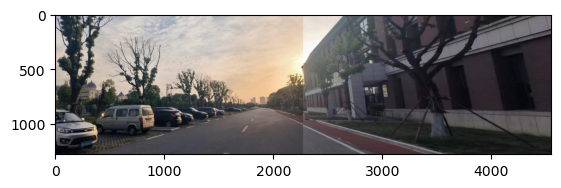

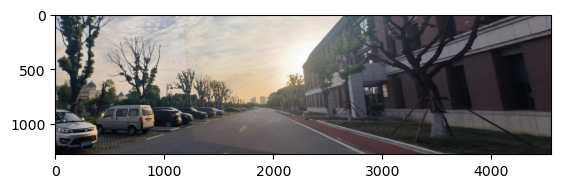

In [1]:
# 图像拼接
import cv2
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# 读取待拼接图像
MIN = 10
img1 = cv.imread('images/2-1.jpg')
img2 = cv.imread('images/2-2.jpg')
# 统一图像大小
height1 = int(img1.shape[0])
width1 = int(img1.shape[1])
dim = (width1, height1)
img2 = cv.resize(img2, dim, interpolation=cv.INTER_AREA)

# 创建SIFT特征点检测
sift = cv.SIFT_create()

# 检测兴趣点并计算描述子
kp1, describe1 = sift.detectAndCompute(img1, None)
kp2, describe2 = sift.detectAndCompute(img2, None)

# 使用OpenCV中的FLANN匹配算法进行特征匹配，并返回最近邻和次近邻匹配的结果
FLANN_INDEX_KDTREE = 0
indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
searchParams = dict(checks=50)
flann = cv.FlannBasedMatcher(indexParams,searchParams)
matches = flann.knnMatch(describe1, describe2, k=2)

# 储存特征匹配最好的优质匹配点对

good = []
for m,n in matches:
    if m.distance < 0.65 * n.distance:
        good.append(m)

# 可视化特征匹配结果,并保存
pic3 = cv.drawMatches(img1=img1, keypoints1=kp1, img2=img2, keypoints2=kp2, matches1to2=good, outImg=None)
cv.imwrite(r'/Users/xionglulu/Downloads/project1/m11.jpg', pic3)

# RANSAC算法计算单应性矩阵
if len(good) > MIN:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    tge_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    M, mask = cv.findHomography(src_pts, tge_pts, cv.RANSAC, 2)
    # 源图像img2图像扭曲（透视变换）
    warpimg = cv.warpPerspective(img2, np.linalg.inv(M), (img1.shape[1] + img2.shape[1], img2.shape[0]))
    cv.namedWindow("warpimg", cv.WINDOW_NORMAL)
    cv.imshow('warpimg',warpimg)
    # 拼接图像
    direct = warpimg.copy()
    direct[0:img1.shape[0], 0:img1.shape[1]] = img1
    rows, cols = img1.shape[:2]

    left = 0
    right = cols
    # 找到img1和warpimg重叠的最左边界
    for col in range(0, cols):
        if img1[:, col].any() and warpimg[:, col].any():
            left = col
        break
    # 找到img1和warpimg重叠的最右边界
    for col in range(cols - 1, 0, -1):
        if img1[:, col].any() and warpimg[:, col].any():
            right = col
        break
    # 图像融合
    res = np.zeros([rows, cols, 3], np.uint8)

    for row in range(0, rows):
        for col in range(0, cols):
            if not img1[row, col].any():
                res[row, col] = warpimg[row, col]
            elif not warpimg[row, col].any():
                res[row, col] = img1[row, col]
            else:
                # 重叠部分加权平均
                srcimgLen = float(abs(col - left))
                testimgLen = float(abs(col - right))
                alpha = srcimgLen / (srcimgLen + testimgLen)
                res[row, col] = np.clip(img1[row, col] * (1 - alpha) + warpimg[row, col] * alpha, 0, 255)


    warpimg[0:img1.shape[0], 0:img1.shape[1]] = res
    img3 = cv.cvtColor(direct, cv.COLOR_BGR2RGB)
    plt.imshow(img3), plt.show()
    plt.imsave('img3.png',img3)
    img4 = cv.cvtColor(warpimg, cv.COLOR_BGR2RGB)
    plt.imshow(img4), plt.show()
    plt.imsave('img4.png',img4)
    cv.waitKey()
    cv.destroyAllWindows()

else:
    print("not enough matches!")